<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/Project_Proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Proposal - Braincore - [C24-BB] Blur or Bokeh
Here is the implementation we have done on our initial idea.

# Outline
- [1. Our Team](#team)
- [2. Initial Idea](#idea)
  - [2.1. Implemented](#idea-implemented)
  - [2.2. Future Work](#idea-future)
- [3. Implementation](#implementation)
  - [3.1. Load Model](#model)
  - [3.2. Helper Functions](#functions)
  - [3.3. Test on HD Images](#test-hd)
  - [3.4. Test on Bokeh Images](#test-bokeh)
  - [3.5. Test on Blur Images](#test-blur)

<a name="team"></a>
## 1. Our Team
- (ML) M172D4KY2673 - Frederic Davidsen
- (ML) M700D4KX3318 - Patricia Ho
- (CC) C293D4KX1211 - Carissa Chandra
- (CC) C296D4KY0023 - Faiz Nur Budi
- (MD) A293D4KX3909 - Cecilia
- (MD) A193D4KY4338 - Dhany Aulia Fajrianto


<a name="idea"></a>
## 2. Initial Idea

<a name="idea-implemented"></a>
### 2.1. Implemented
We will do this classification task by combining the power of object detection and edge detection. The object detection model is implemented using the transfer learning technique with pre-trained MobileNet V2 as image feature extractor. The Laplacian is used for edge detection.

The main idea is that this classifier will firstly identify if there is any object in the input image. The classifier then calculates the variance of Laplacian of the whole image using the OpenCV module. If the variance is high, the image is classified as an HD image. If the variance is lower, the classifier will do further checks on the detected objects by calculating the variance of Laplacian on these isolated parts of the image. If the variance of Laplacian of the isolated images is high, the image is classified as bokeh image. Conversely, the image with very low variance of Laplacian is classified as a blur image.

<a name="idea-future"></a>
### 2.2. Future Work
Since the classifier utilizes object detection, it can identify if the input image does not contain an object (product). Therefore, the system can tell the user to upload another image that contains a product rather than, for example, a high quality ocean image. Additionally, the classifier can be tuned to restrict the variation of objects (products) in the image. For example, an image is only allowed to have a maximum of 3 types of products since too many variations may confuse or distract customers. The system will reject the image if it contains no object or more than 3 objects (products). This feature is proposed to provide better feedback for users as classifying an image only by 3 classes (HD, bokeh, or blur) may not be clear for them.

This feature can be developed further. We can adjust the classifier to verify that the input image matches the tag of the product. For example, one is selling shoes but trying to upload a shirt image. It does not make sense and the system should reject the image.

Further improvement is aiming on using different models for object detection and better classification thresholds. We believe clustering techniques can help us to accomplish this task.

<a name="implementation"></a>
## 3. Implementation

In [ ]:
import cv2
import PIL
import tempfile
import urllib.request
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six import BytesIO
from PIL import Image, ImageOps
from six.moves.urllib.request import urlopen

<a name="model"></a>
### 3.1. Load Model



In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
model = hub.load(module_handle)
model.signatures.keys()
detector = model.signatures["default"]

<a name="functions"></a>
### 3.2. Helper Functions

In [ ]:
def variance_of_laplacian(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()


def download_and_resize_image(url, new_width=256, new_height=256):
    _, filename = tempfile.mkstemp(suffix=".jpg")

    request = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    response = urlopen(request)

    image_data = response.read()
    image_data = BytesIO(image_data)

    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), PIL.Image.Resampling.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)

    return {
        "filename": filename,
        "image": pil_image_rgb,
        "var": variance_of_laplacian(filename)
    }


def run_detector(detector, path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]

    detection_result = detector(image)
    result_dict = {key:value.numpy() for key, value in detection_result.items()}

    result = {"detection_scores": [], "detection_class_entities": [], "detection_boxes": []}
    for i in range(len(result_dict["detection_scores"])):
      if result_dict["detection_scores"][i] >= 0.25:
        result["detection_scores"].append(result_dict["detection_scores"][i])
        result["detection_class_entities"].append(result_dict["detection_class_entities"][i])
        result["detection_boxes"].append(result_dict["detection_boxes"][i])

    return result


def sigmoid(x, threshold):
    k = 0.01 # Sigmoid steepness
    result = 1 / (1 + np.exp(-k * (x - threshold)))
    return round(result, 2)


def harmonic_mean(image_prob, object_prob):
    result = 4 * image_prob * object_prob / (3 * image_prob + object_prob)
    return round(result, 2)


def predict(image_url, show_image=True):
    downloaded_image = download_and_resize_image(image_url, 1280, 856)
    im_width, im_height = downloaded_image["image"].size

    if show_image:
      plt.figure(figsize=(3, 2))
      plt.imshow(downloaded_image["image"])
      plt.axis("off")
      plt.show()

    detector_result = run_detector(detector, downloaded_image["filename"])

    object_var_list = []
    for box in detector_result["detection_boxes"]:
      _, filename = tempfile.mkstemp(suffix=".jpg")

      ymin, xmin, ymax, xmax = box
      left, right, top, bottom = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)

      cropped_image = downloaded_image["image"].crop((left, top, right, bottom))
      cropped_image.save(filename, format="JPEG", quality=90)
      object_var_list.append(variance_of_laplacian(filename))

    object_var_avg = sum(object_var_list) / (len(object_var_list) + 0.001)


    threshold_hd = 300
    threshold_bokeh_img = 60
    threshold_bokeh_obj = 60
    threshold_blur = -300

    if downloaded_image["var"] > 300:
      cls = "HD"
      prob = sigmoid(downloaded_image["var"], threshold_hd)
    elif downloaded_image["var"] > 60 and object_var_avg > 60:
      cls = "Bokeh"
      prob_img = sigmoid(downloaded_image["var"], threshold_bokeh_img)
      prob_obj = sigmoid(object_var_avg, threshold_bokeh_obj)
      prob = harmonic_mean(prob_img, prob_obj)
    else:
      cls = "Blur"
      prob = sigmoid(-downloaded_image["var"], threshold_blur)

    return {
        "class": cls,
        "probability": prob,
        "image_var": round(downloaded_image["var"], 2),
        "object_var": round(object_var_avg, 2)
    }


def print_result(image_list):
    for i, url in enumerate(image_list):
      print(f"Image {i+1}")
      result = predict(url, show_image=True)
      print(result, "\n")

<a name="test-hd"></a>
### 3.3. Test on HD Images

Image 1


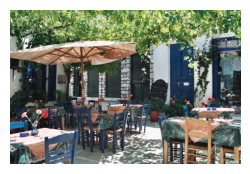

{'class': 'HD', 'probability': 1.0, 'image_var': 1567.47, 'object_var': 1151.42} 

Image 2


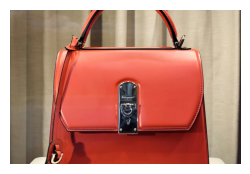

{'class': 'HD', 'probability': 0.8, 'image_var': 436.86, 'object_var': 592.17} 

Image 3


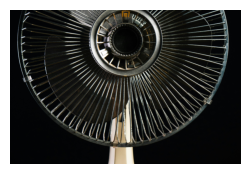

{'class': 'HD', 'probability': 1.0, 'image_var': 2304.53, 'object_var': 2621.64} 

Image 4


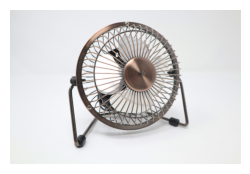

{'class': 'HD', 'probability': 0.97, 'image_var': 653.2, 'object_var': 1700.47} 

Image 5


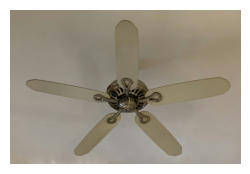

{'class': 'Bokeh', 'probability': 0.55, 'image_var': 65.73, 'object_var': 82.98} 

Image 6


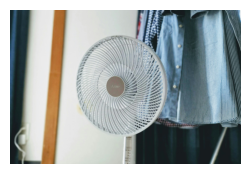

{'class': 'HD', 'probability': 0.91, 'image_var': 527.12, 'object_var': 757.2} 



In [ ]:
hd_image_list = [
    "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg", # table + chair
    "https://images.unsplash.com/photo-1584917865442-de89df76afd3", # bag
    "https://images.unsplash.com/photo-1565151443833-29bf2ba5dd8d", # fan
    "https://images.unsplash.com/photo-1564510182791-29645da7fac4", # fan
    "https://images.unsplash.com/photo-1609519479841-5fd3b2884e17", # fan
    "https://images.unsplash.com/photo-1568392816241-44d223d4d490", # fan
]
print_result(hd_image_list)

<a name="test-bokeh"></a>
### 3.4. Test on Bokeh Images

Image 1


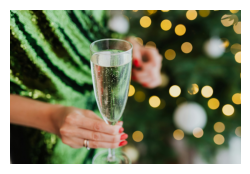

{'class': 'Bokeh', 'probability': 0.81, 'image_var': 77.09, 'object_var': 429.87} 

Image 2


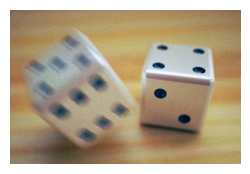

{'class': 'Blur', 'probability': 0.94, 'image_var': 20.84, 'object_var': 22.73} 

Image 3


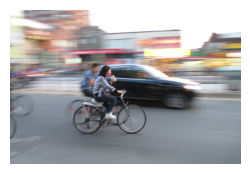

{'class': 'Bokeh', 'probability': 0.72, 'image_var': 109.6, 'object_var': 177.52} 

Image 4


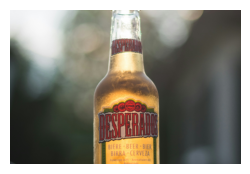

{'class': 'Bokeh', 'probability': 0.69, 'image_var': 62.99, 'object_var': 195.33} 

Image 5


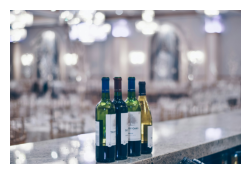

{'class': 'Bokeh', 'probability': 0.91, 'image_var': 156.63, 'object_var': 1043.54} 

Image 6


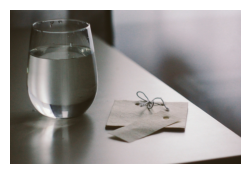

{'class': 'Bokeh', 'probability': 0.67, 'image_var': 85.17, 'object_var': 153.27} 

Image 7


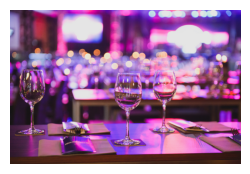

{'class': 'Bokeh', 'probability': 0.96, 'image_var': 232.43, 'object_var': 649.66} 

Image 8


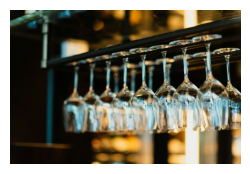

{'class': 'Blur', 'probability': 0.75, 'image_var': 191.92, 'object_var': 0.0} 



In [ ]:
bokeh_image_list = [
    "https://images.pexels.com/photos/5472971/pexels-photo-5472971.jpeg", # glass
    "https://i0.wp.com/www.fxfx.net/wp-content/uploads/2010/02/motion_blur_effect_covwer1.jpg", # dice
    "https://content.instructables.com/FXU/3HFB/ID1SQKLE/FXU3HFBID1SQKLE.jpg", # biking
    "https://images.unsplash.com/photo-1533218065445-9c1478886300", # bottle
    "https://images.unsplash.com/photo-1517268360635-01df33413763", # many bottle
    "https://images.unsplash.com/photo-1604960065972-b6b8a4c60674", # glass
    "https://images.unsplash.com/photo-1516997121675-4c2d1684aa3e", # many glass
    "https://images.unsplash.com/photo-1515674213736-54d14b4285b4", # many glass
]
print_result(bokeh_image_list)

<a name="test-blur"></a>
### 3.5. Test on Blur Images

Image 1


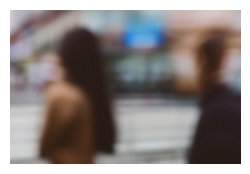

{'class': 'Blur', 'probability': 0.95, 'image_var': 2.42, 'object_var': 2.16} 

Image 2


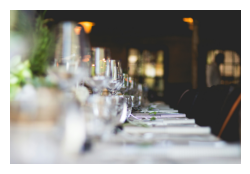

{'class': 'Bokeh', 'probability': 0.64, 'image_var': 70.6, 'object_var': 136.61} 

Image 3


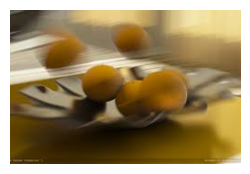

{'class': 'Blur', 'probability': 0.95, 'image_var': 2.96, 'object_var': 0.0} 

Image 4


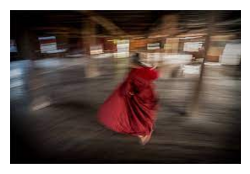

{'class': 'Blur', 'probability': 0.95, 'image_var': 6.38, 'object_var': 6.32} 

Image 5


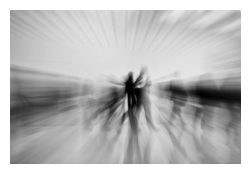

{'class': 'Blur', 'probability': 0.95, 'image_var': 4.82, 'object_var': 0.0} 

Image 6


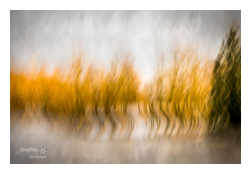

{'class': 'Blur', 'probability': 0.9, 'image_var': 79.16, 'object_var': 0.0} 



In [ ]:
blur_image_list = [
    "https://imagedelivery.net/9sCnq8t6WEGNay0RAQNdvQ/UUID-cl8j86rxl1803tdqymvtqf8e8/public", # people
    "https://images.unsplash.com/photo-1484156818044-c040038b0719", # table with glass
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ80JWO79c5ykzm7sqXBYtskYzPJgBaaOWOdAwTMkPl4w&s",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmp553iGf3G2QlUssjNi3Q8zlYkfwheEcKKMJmy5Gwxh8AjTaLorIW-4Uh7Kp1eFhD1d8&usqp=CAU",
    "https://images.saatchiart.com/saatchi/676261/art/2999888/2069781-HSC00001-7.jpg",
    "https://www.doubleexposure.ca/wp-content/uploads/2021/02/winter-0388.jpg"
]
print_result(blur_image_list)